In [1]:
import albumentations as A

import torch

from torchvision import models
from torchvision import transforms as T

from pathlib import Path

from PIL import Image

import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

In [5]:
torch.cuda.device_count()

2

In [9]:
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

NVIDIA GeForce RTX 3080 Ti
NVIDIA GeForce RTX 3080 Ti


In [3]:
def transform_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    img_transforms = A.Compose([A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)])
    aug = img_transforms(image = img)
    img = Image.fromarray(aug['image'])

    ori = img

    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    
    img = t(img)
    img = img.to(device)

    return [img.unsqueeze(0), ori]

In [4]:
TEST_PATH = "/home/enfycius/Datasets/김종혁/research/"

In [5]:
import numpy as np
import cv2

import os

In [6]:
def get_files(path):
    files = []
    files_path = []

    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            files.append(filename)
            files_path.append(dirname + filename)

    return [files, files_path]

In [7]:
def path_to_img(paths, flag=cv2.IMREAD_COLOR):
    imgs = []

    _, paths = get_files(paths)

    for path in paths:
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        imgs.append(img)
        
    return [imgs, paths]

In [8]:
_, bolt_img_paths = get_files(TEST_PATH + "bolt" + "/")
_, connection_img_paths = get_files(TEST_PATH + "connection" + "/")

In [9]:
bolt_img_paths

['/home/enfycius/Datasets/김종혁/research/bolt/IMG_0263.png']

In [10]:
connection_img_paths

['/home/enfycius/Datasets/김종혁/research/connection/IMG_0263.png']

In [11]:
bolt_sample_img = cv2.imread(bolt_img_paths[0])
connection_sample_img = cv2.imread(connection_img_paths[0])

In [12]:
_, bolt_sample_img = cv2.threshold(bolt_sample_img, 1, 128, cv2.THRESH_BINARY)
_, connection_sample_img = cv2.threshold(connection_sample_img, 2, 255, cv2.THRESH_BINARY)

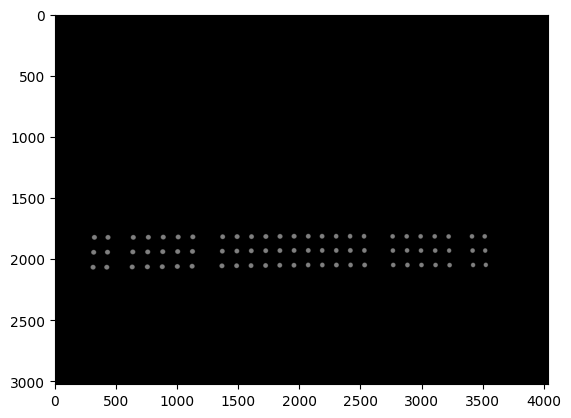

In [13]:
plt.imshow(bolt_sample_img)
plt.show()

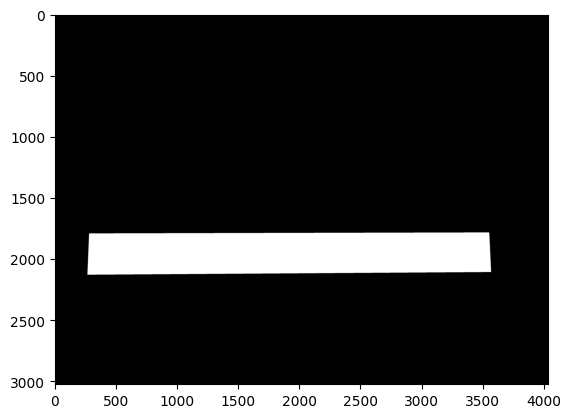

In [14]:
plt.imshow(connection_sample_img)
plt.show()

In [15]:
import sympy

In [16]:
def appx_best_fit_ngon(mask_cv2, n: int = 4):
    mask_cv2_gray = cv2.cvtColor(mask_cv2, cv2.COLOR_RGB2GRAY)
    
    contours, _ = cv2.findContours(
        mask_cv2_gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
    )

    hull = cv2.convexHull(contours[0])
    hull = np.array(hull).reshape((len(hull), 2))

    hull = [sympy.Point(*pt) for pt in hull]

    while len(hull) > n:
        best_candidate = None

        for edge_idx_1 in range(len(hull)):
            edge_idx_2 = (edge_idx_1 + 1) % len(hull)

            adj_idx_1 = (edge_idx_1 - 1) % len(hull)
            adj_idx_2 = (edge_idx_1 + 2) % len(hull)

            edge_pt_1 = sympy.Point(*hull[edge_idx_1])
            edge_pt_2 = sympy.Point(*hull[edge_idx_2])
            adj_pt_1 = sympy.Point(*hull[adj_idx_1])
            adj_pt_2 = sympy.Point(*hull[adj_idx_2])

            subpoly = sympy.Polygon(adj_pt_1, edge_pt_1, edge_pt_2, adj_pt_2)
            angle1 = subpoly.angles[edge_pt_1]
            angle2 = subpoly.angles[edge_pt_2]

            if sympy.N(angle1 + angle2) <= sympy.pi:
                continue

            adj_edge_1 = sympy.Line(adj_pt_1, edge_pt_1)
            adj_edge_2 = sympy.Line(edge_pt_2, adj_pt_2)
            intersect = adj_edge_1.intersection(adj_edge_2)[0]

            area = sympy.N(sympy.Triangle(edge_pt_1, intersect, edge_pt_2).area)

            if best_candidate and best_candidate[1] < area:
                continue

            better_hull = list(hull)
            better_hull[edge_idx_1] = intersect
            del better_hull[edge_idx_2]
            best_candidate = (better_hull, area)

        if not best_candidate:
            raise ValueError("Could not find the best fit n-gon!")

        hull = best_candidate[0]

    hull = [(int(x), int(y)) for x, y in hull]

    return hull

In [17]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis = 1)

    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

In [18]:
def four_point_transform(image, pts):
	rect = order_points(pts)
	(tl, tr, br, bl) = rect

	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))

	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))

	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")

	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

	return warped

In [19]:
hull = appx_best_fit_ngon(connection_sample_img)

In [20]:
hull

[(3566, 2108), (264, 2130), (278, 1792), (3551, 1784)]

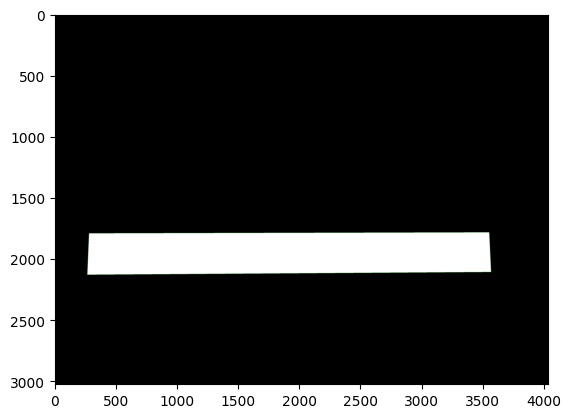

In [21]:
for idx in range(len(hull)):
    next_idx = (idx + 1) % len(hull)
    plt.imshow(cv2.line(connection_sample_img, hull[idx], hull[next_idx], (0, 255, 0), 1))

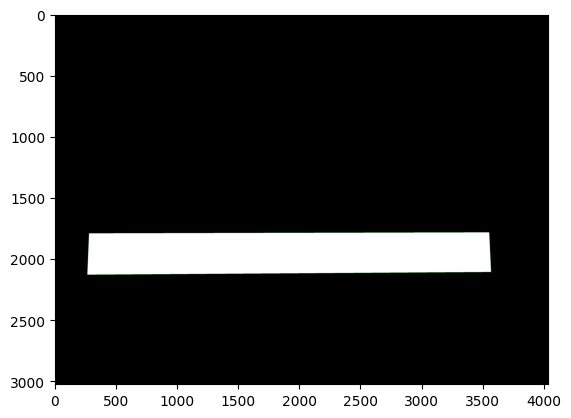

In [22]:
for pt in hull:
    plt.imshow(cv2.circle(connection_sample_img, pt, 2, (255, 0, 0), 2))

In [23]:
def transform_resize(img):
    img_transforms = A.Compose([A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)])
    aug = img_transforms(image = img)

    img = Image.fromarray(aug['image'])

    return img

In [24]:
pts = np.array(hull, dtype = "float32")

In [25]:
REF_PATH = "/home/enfycius/Datasets/김종혁/research/"

In [26]:
ref_img = cv2.imread(REF_PATH + bolt_img_paths[0].split('/')[-1], cv2.COLOR_BGR2RGB)

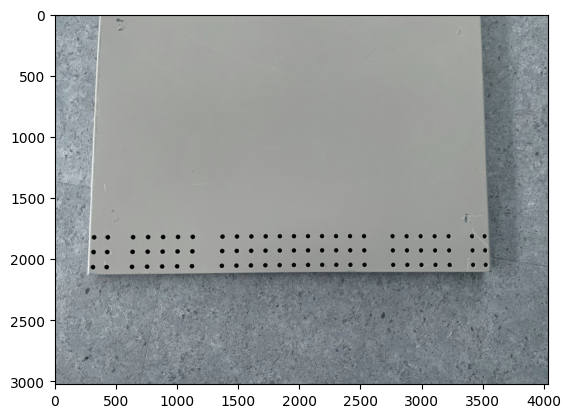

In [27]:
plt.imshow(ref_img)
plt.show()

In [28]:
# ref_img = transform_resize(ref_img)

In [29]:
ref_img = np.array(ref_img)

In [30]:
warped = four_point_transform(ref_img, pts)

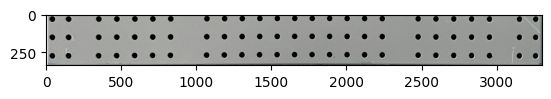

In [31]:
plt.imshow(warped)
plt.show()

In [32]:
warped.shape

(338, 3302, 3)

In [33]:
img = cv2.imread(REF_PATH + bolt_img_paths[0].split('/')[-1], cv2.COLOR_BGR2RGB)

In [34]:
REPORT_PATH = "/home/enfycius/Desktop/train_report_v2"

In [35]:
def processing(img, img_name, img_extension, connection_label, bolt_label):
    hull = appx_best_fit_ngon(connection_label)
    pts = np.array(hull, dtype = "float32")
    
    ref_img = img
    # ref_img = transform_resize(ref_img)
    ref_img = np.array(ref_img)

    ref_bolt_label = bolt_label
    # ref_bolt_label = transform_resize(ref_bolt_label)
    ref_bolt_label = np.array(ref_bolt_label)

    f, axs = plt.subplots(1, 4, figsize=(25, 25))

    axs[0].imshow(img)

    # cv2.imwrite(REPORT_PATH + '/' + img_name + "_connection_label_only" + img_extension, connection_label)

    for idx in range(len(hull)):
        next_idx = (idx + 1) % len(hull)
        axs[1].imshow(cv2.line(connection_label, hull[idx], hull[next_idx], (0, 255, 0), 10))

    for pt in hull:
        axs[1].imshow(cv2.circle(connection_label, pt, 2, (0, 0, 255), 10))

    # cv2.imwrite(REPORT_PATH + '/' + img_name + "_original" + img_extension, img)
    # cv2.imwrite(REPORT_PATH + '/' + img_name + "_connection_label" + img_extension, bolt_label)
    # cv2.imwrite(REPORT_PATH + '/' + img_name + "_connection_label_detect" + img_extension, connection_label)
    
    warped = four_point_transform(ref_img, pts)
    warped_bolt = four_point_transform(ref_bolt_label, pts)

    # cv2.imwrite(REPORT_PATH + '/' + img_name + "_warped_bolt" + img_extension, warped_bolt)

    axs[2].imshow(warped)
    axs[3].imshow(warped_bolt)
    
    print(warped.shape) 

    return [warped, warped_bolt]

(344, 3309, 3)


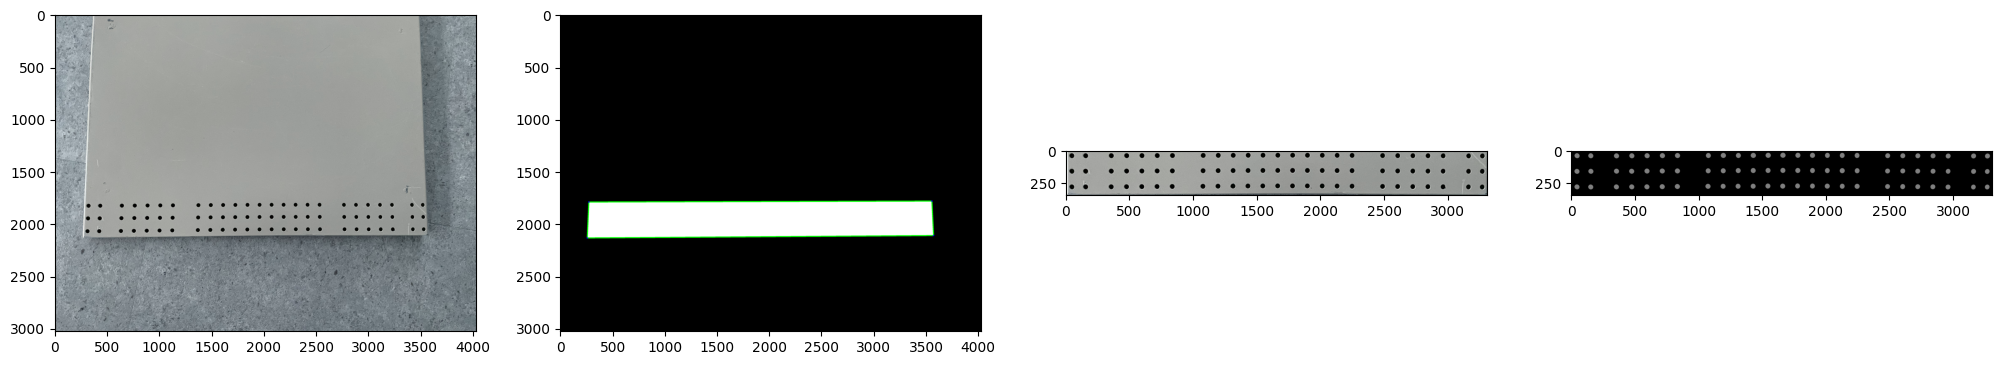

In [36]:
warped, warped_bolt = processing(img, bolt_img_paths[0].split('/')[-1][:-4], bolt_img_paths[0].split('/')[-1][-4:], connection_sample_img, bolt_sample_img)

In [62]:
dst = cv2.resize(warped_bolt, (5577, 540))

In [63]:
dst.shape

(540, 5577, 3)

In [64]:
dst = cv2.cvtColor(dst, cv2.COLOR_RGB2GRAY)

In [65]:
contours,hierarchy = cv2.findContours(dst, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [66]:
cX_lst = []
cY_lst = []

In [67]:
for cnt in contours:
    (x, y), radius = cv2.minEnclosingCircle(cnt)
    cX_lst.append(int(x))
    cY_lst.append(int(y))
    center = (int(x), int(y))
    radius = int(radius)
    cv2.circle(dst, center, radius, (255, 0, 0), 2)

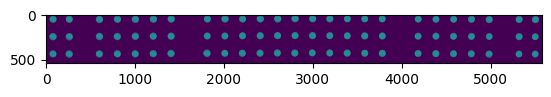

In [68]:
plt.imshow(dst)
plt.show()

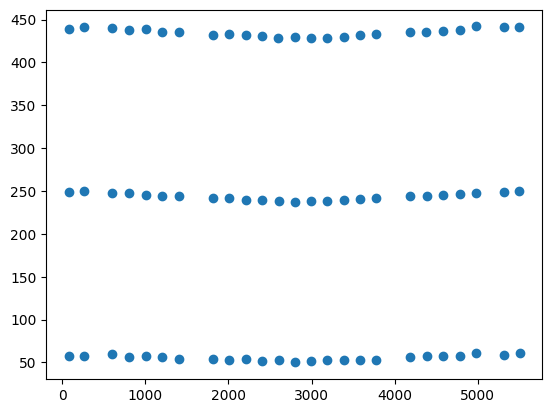

In [70]:
plt.scatter(cX_lst, cY_lst)
plt.show()

In [54]:
import pandas as pd

In [55]:
radius_mean_sup_lst = []
radius_sup_lst = []
radius_sub_lst = []

In [56]:
take_capture = True

In [57]:
datasets = pd.DataFrame()

In [58]:
dst = cv2.resize(warped_bolt, (5577, 540))

# The below is a modified version.

dst2 = cv2.cvtColor(dst, cv2.COLOR_RGB2GRAY)

contours, hierarchy = cv2.findContours(dst2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

cX_lst = []
cY_lst = []
# radius_lst = []

bolt_holes_info = pd.DataFrame()

for idx, cnt in enumerate(contours):
    (x, y), radius = cv2.minEnclosingCircle(cnt)
    M = cv2.moments(cnt)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    # center = (int(x), int(y))
    radius = int(radius)
    # radius_sub_lst.append([cX, cY])
    radius_sub_lst.append(radius)

    if take_capture:
        cX_lst.append(cX)
        cY_lst.append(cY)
        # radius_lst.append(radius)


    # cv2.circle(dst, (int(x), int(y)), int(radius), (255,0,0), 2)

    cv2.circle(dst, (cX, cY), 1, (255, 0, 0), 2)
    cv2.putText(dst, str(idx), (cX, cY), cv2.FONT_HERSHEY_PLAIN, 10, (255, 0, 0), 5, cv2.LINE_AA)

bolt_holes_info['centerX'] = cX_lst
bolt_holes_info['centerY'] = cY_lst
# bolt_holes_info['radius'] = radius_lst
bolt_holes_info = bolt_holes_info.sort_values(by=['centerY'])

one_row_bolts = bolt_holes_info[:25].sort_values(by=['centerX'])
# one_row_bolts = one_row_bolts.reshape(-1, 1)
two_row_bolts = bolt_holes_info[25:50].sort_values(by=['centerX'])
# two_row_bolts = two_row_bolts.reshape(-1, 1)
three_row_bolts = bolt_holes_info[50:].sort_values(by=['centerX'])
# three_row_bolts = three_row_bolts.reshape(-1, 1)

one_row_bolts = pd.DataFrame(one_row_bolts.values.reshape(-1, 1))
two_row_bolts = pd.DataFrame(two_row_bolts.values.reshape(-1, 1))
three_row_bolts = pd.DataFrame(three_row_bolts.values.reshape(-1, 1))

# print(one_row_bolts.shape)

one_row_bolts.reset_index(drop=True, inplace=True)
two_row_bolts.reset_index(drop=True, inplace=True)
three_row_bolts.reset_index(drop=True, inplace=True)

# print(pd.concat([one_row_bolts, two_row_bolts, three_row_bolts], axis=1, ignore_index=True).melt())

# datasets = pd.concat([one_row_bolts, two_row_bolts, three_row_bolts], axis=1, ignore_index=True).melt()['value'].T

# datasets.set_index([str(i) for i in range(0, 150)])

data = pd.concat([one_row_bolts, two_row_bolts, three_row_bolts], axis=1).melt()['value']


datasets = datasets.append(data, ignore_index=True)

# take_capture = False

plt.imshow(dst)
plt.show()

# mean of bolt holes
radius_sub_lst = np.array(radius_sub_lst)
radius_mean_sup_lst.append(radius_sub_lst.mean())

# radius_sub_lst = np.array(radius_sub_lst)

# radius_not_exist_nan = radius_sub_lst[~np.isnan(np.array(radius_sub_lst))]

# radius_sup_lst.append(radius_sub_lst)

AttributeError: 'DataFrame' object has no attribute 'append'